# Fake News Detection System

## 0. Import libraries and load datasets

In [ ]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from google.colab import drive

import re  # Data Preprocessing

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

!pip install --upgrade gensim
from gensim.parsing.preprocessing import remove_stopwords
import gensim.downloader

pre_ft_vectors = gensim.downloader.load("glove-wiki-gigaword-100")

# Import the appropriate vectorizers (CountVect., and TF-IDF Vect.)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer as cvect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer as tfvect
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold as kfold

# Import spacy for the lemmatisation process
import spacy
nlp = spacy.load('en_core_web_sm')

from wordcloud import WordCloud  # Data Visualization

import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

In [ ]:
true_ds = 'True.csv'
fake_ds = 'Fake.csv'

# IMPORTANT: If you want to import from drive, set this to "True".
import_from_drive = False

if import_from_drive:
  drive.mount('/content/drive')
  at = r'/content/drive/MyDrive/YOUR-DIRECTORY-GOES-HERE'
else:
  at = 'YOUR-LINK-GOES-HERE'

# True news
true_df = pd.read_csv(at + true_ds)

# Fake news
fake_df = pd.read_csv(at + fake_ds)

In [ ]:
# Work with a percentage of the data, in order to build the core of the project faster
p = 0.2  # Keep 20% of the data.
true_df = true_df.head(int(p * true_df.shape[0]))
fake_df = fake_df.head(int(p * fake_df.shape[0]))

Misc. Note: In this file, we are just showcasing our pipeline, so we work with 20% of the datasets.

## 1. Data Preprocessing

In the Preprocess step, we remove whitespace characters and punctuation marks from each article. We also remove articles with missing 'title' or 'text' fields entirely from our dataframes.

In [ ]:
def clean_string(sent):
    sent = sent.lower()
    sent = re.sub('\n|\r|\t', '', sent)   # Remove whitespace chars
    sent = re.sub(r'[^\w\s]+', '', sent)  # Remove punctuation
    return sent

def preprocess(df):
    df.dropna(subset = ['title', 'text'], inplace = True)  # Remove rows with missing values in either title or text
    vfunc = np.vectorize(clean_string)    # Speed up string clean-up using vectorization
    df['title'] = vfunc(df['title'])
    df['text'] = vfunc(df['text'])
    return df

In [ ]:
true_df = preprocess(true_df)
fake_df = preprocess(fake_df)

## 2. Data Exploration

### (a) "Title" keywords visualization with WordCloud

In [ ]:
def disp_wordcloud(df):
    stop_words = nltk.corpus.stopwords.words('english')  # Remove stopwords
    wc = WordCloud(max_words=250, stopwords=stop_words).generate(' '.join(df['title'].tolist()))
    plt.figure(figsize=(10,10))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    print()


Visualizing titles from True-news:



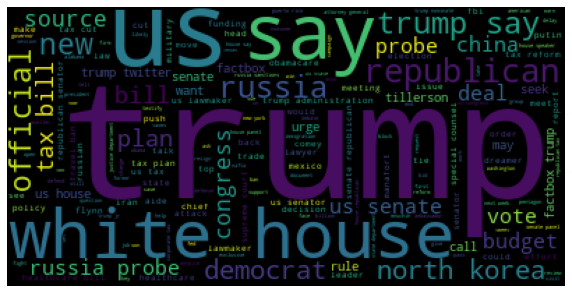

In [ ]:
print('\nVisualizing titles from True-news:\n')
disp_wordcloud(true_df)


Visualizing titles from Fake-news:



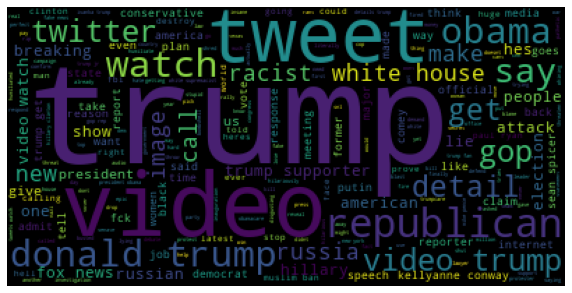

In [ ]:
print('\nVisualizing titles from Fake-news:\n')
disp_wordcloud(fake_df)

### (b) Character counts in "Title" and "Text"

In [ ]:
# Create a new field storing the character count of each Article's field.
def add_char_count_col(df, field):
    df['char_count_' + field] = [len(entry) for entry in df[field].to_list()]

def disp_histogram_char_count(df, field, news_type):
    ax = df['char_count_' + field].plot(kind='hist', legend=False,
                    title=f'Char count distribution in {news_type} based on field: {field}')
    ax.set_xlabel('Chars')
    ax.set_ylabel('News')
    plt.xticks(rotation=0)
    plt.show()
    print()

def plot_average_char_count(true_df, fake_df, field):
    f = fake_df['char_count_' + field].mean()  # Get average char count of 'field'.
    t = true_df['char_count_' + field].mean()
    df = pd.DataFrame([['True', int(t)], ['Fake', int(f)]], columns=['News', 'Characters'])
    df.plot(x='News', y='Characters', kind='bar', width=0.3, xlabel='Type of News', legend=False,
                    ylabel='Chars', title=f'Average char count in each type of news based on field: {field}')         
    plt.xticks(rotation=0)
    plt.show()
    print()

def char_stats(true_df, fake_df, field):
    add_char_count_col(true_df, field)  # Get char count for each Dataframe.
    add_char_count_col(fake_df, field)
    disp_histogram_char_count(true_df, field, 'True-news')
    disp_histogram_char_count(fake_df, field, 'Fake-news')
    plot_average_char_count(true_df, fake_df, field)
    true_df.drop('char_count_' + field, axis=1, inplace=True)  # Remove auxiliary columns.
    fake_df.drop('char_count_' + field, axis=1, inplace=True)



Showing stats regarding "Title" field



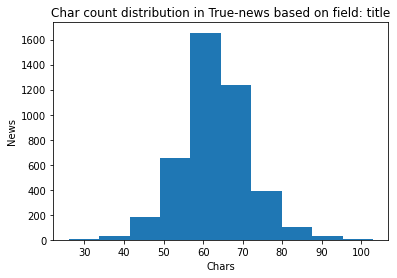

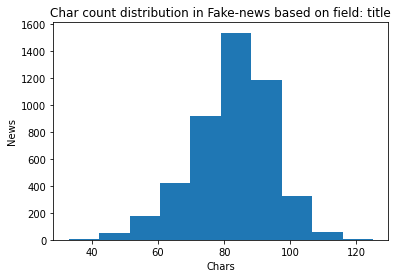

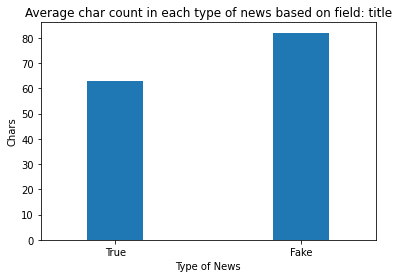

In [ ]:
print('\nShowing stats regarding "Title" field\n')
char_stats(true_df, fake_df, 'title')


Showing stats regarding "Text" field



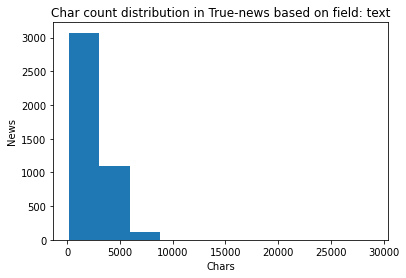

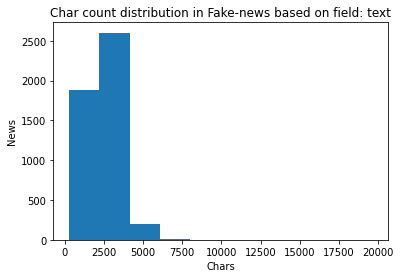

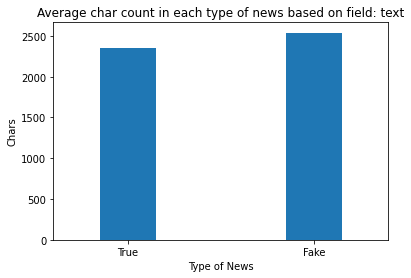

In [ ]:
print('\nShowing stats regarding "Text" field\n')
char_stats(true_df, fake_df, 'text')

We observe that, on average, "Fake news" contain more characters than "True news". This is probably due to the "Fake news" authors' efforts to make their articles seem true using longer and more descriptive titles and content.

### (c) Word counts in "Title" and "Text"

In [ ]:
# Create a new field storing the word count of each Article's field.
def add_word_count_col(df, field):
    df['word_count_' + field] = [len(entry.split()) for entry in df[field].to_list()]

def disp_histogram_word_count(df, field, news_type):
    ax = df['word_count_' + field].plot(kind='hist', legend=False,
                    title=f'Word count distribution in {news_type} based on field: {field}')
    ax.set_xlabel('Words')
    ax.set_ylabel('News')
    plt.xticks(rotation=0)
    plt.show()
    print()


def plot_average_word_count(true_df, fake_df, field):
    f = fake_df['word_count_' + field].mean()
    t = true_df['word_count_' + field].mean()
    df = pd.DataFrame([['True', int(t)], ['Fake', int(f)]], columns=['News', 'Words'])
    df.plot(x='News', y='Words', kind='bar', width=0.3, xlabel='Type of News', legend=False,
                    ylabel='Num. of Words', title=f'Average word count in each type of news based on field: {field}')         
    plt.xticks(rotation=0)
    plt.show()
    print()

def word_stats(true_df, fake_df, field):
    add_word_count_col(true_df, field)
    add_word_count_col(fake_df, field)
    disp_histogram_word_count(true_df, field, 'True-news')
    disp_histogram_word_count(fake_df, field, 'Fake-news')
    plot_average_word_count(true_df, fake_df, field)
    true_df.drop('word_count_' + field, axis=1, inplace=True)
    fake_df.drop('word_count_' + field, axis=1, inplace=True) 


Showing stats regarding "Title" field



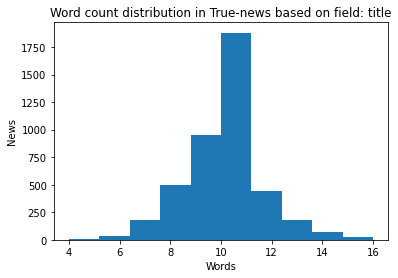

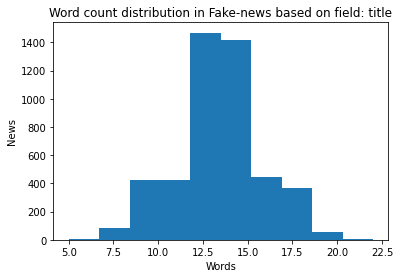

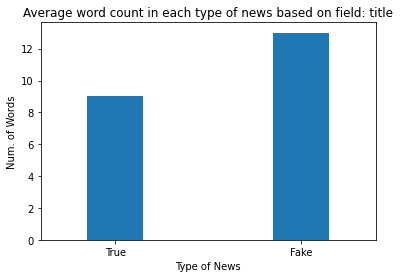

In [ ]:
print('\nShowing stats regarding "Title" field\n')
word_stats(true_df, fake_df, 'title')


Showing stats regarding "Text" field



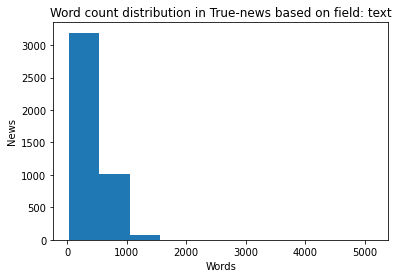

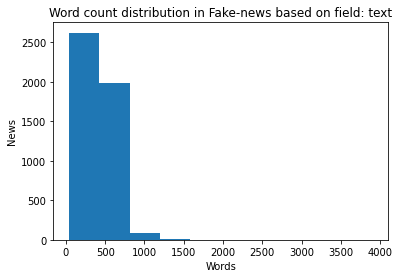

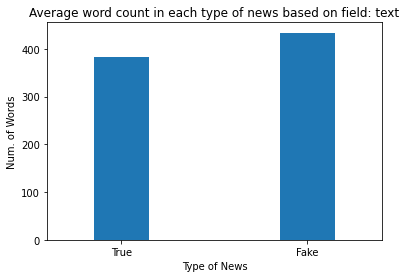

In [ ]:
print('\nShowing stats regarding "Text" field\n')
word_stats(true_df, fake_df, 'text')

We observe that, once again, "Fake news" contain more words than "True news" on average.

### (d) Word counts in "Title" and "Text", excluding stopwords

In [ ]:
def remove_stopwords_from_str(string):
    return "".join(remove_stopwords(string))

# Create a new field storing the word count of each Article's field, excluding stopwords.
def add_word_count_col_no_stopwords(df, field):
    df['word_count_' + field] = [len(remove_stopwords_from_str(entry).split()) for entry in df[field].to_list()]

def word_stats_no_stopwords(true_df, fake_df, field):
    add_word_count_col_no_stopwords(true_df, field)
    add_word_count_col_no_stopwords(fake_df, field)
    disp_histogram_word_count(true_df, field, 'True-news')
    disp_histogram_word_count(fake_df, field, 'Fake-news')
    plot_average_word_count(true_df, fake_df, field)
    true_df.drop('word_count_' + field, axis=1, inplace=True)  # Remove auxiliary columns.
    fake_df.drop('word_count_' + field, axis=1, inplace=True) 


Showing stats regarding "Title" field without Stopwords



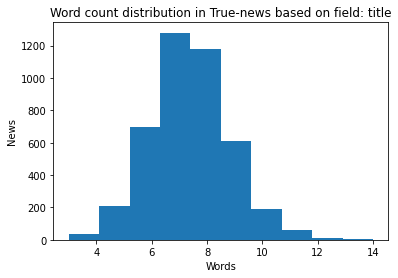

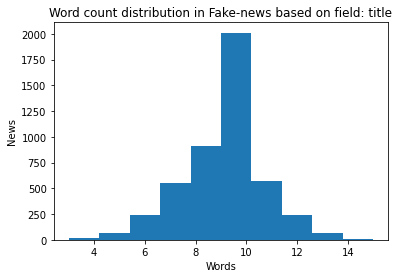

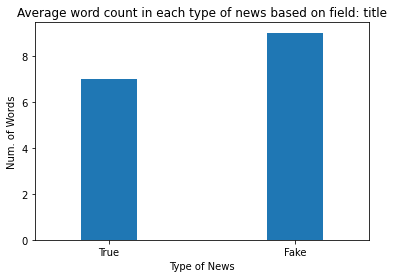

In [ ]:
print('\nShowing stats regarding "Title" field without Stopwords\n')
word_stats_no_stopwords(true_df, fake_df, 'title')


Showing stats regarding "Text" field without Stopwords



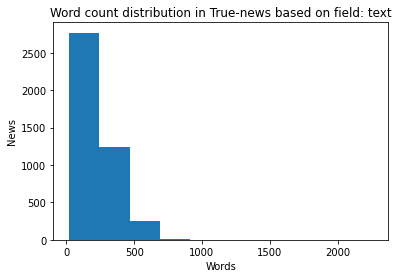

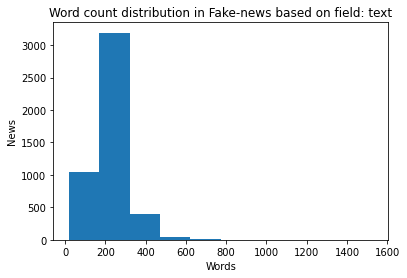

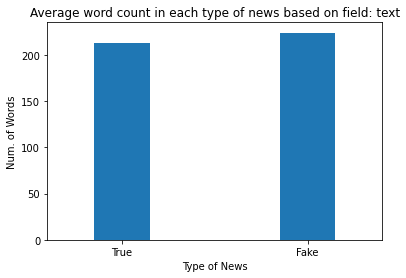

In [ ]:
print('\nShowing stats regarding "Text" field without Stopwords\n')
word_stats_no_stopwords(true_df, fake_df, 'text')

Again, we observe that "Fake news" on average contain more words, excluding stopwords, than "True news", but with a pretty narrow margin. This implies that stopwords are used more in "Fake news" than in "True news", possibly in order to make the article seem more realistic.

### (e) Most frequent bigrams in "title" and "text" fields

In [ ]:
def lemmatize(string):
  lem = [token.lemma_ for token in nlp(string, disable=["parser", "ner"]) if token.lemma_ != '-PRON-']
  string = " ".join(lem)
  return string

# Lemmatise all of the titles and descriptions
def lemmatize_title_text(df):
    df_lem = df.copy()
    vfunc = np.vectorize(lemmatize)    # Speed up string clean-up using vectorization
    df_lem['text']  = vfunc(df_lem['text'])
    df_lem['title'] = vfunc(df_lem['title'])
    return df_lem

# Extract descriptions and titles and merge them into individual strings
def extract_title_text(df):
    texts = " ".join(df['text'].to_list()).strip()
    titles = " ".join(df['title'].to_list()).strip()
    return (titles, texts)

def lemmatize_and_extract(df):
    lem_df = lemmatize_title_text(df)
    titles_texts = extract_title_text(lem_df)
    return lem_df, titles_texts

In [ ]:
true_df_lem, true_tt = lemmatize_and_extract(true_df)
fake_df_lem, fake_tt = lemmatize_and_extract(fake_df)

In [ ]:
# Create a bow dataframe with bigrams
def create_bow_df(tt, stopw):
    bigr = cvect(ngram_range=(2, 2), stop_words=stopw, min_df=2, max_df=9999)
    transf = bigr.fit_transform(tt)
    bigr_df = pd.DataFrame(transf.toarray(), columns = bigr.get_feature_names())
    return bigr_df

# Get the bigrams frequency in the Dataframe
def get_bigrams_freq(bigr_df, field) -> dict:
    index = 0 if field == 'title' else 1
    freq = bigr_df.iloc[index].to_list()
    bigr = bigr_df.columns.to_list()
    freq = list(zip(bigr, freq))
    return dict(freq)

def disp_wordcloud_bigr(freq, max_words_wc = 20):
    wc = WordCloud(max_words = max_words_wc).generate_from_frequencies(freq)
    plt.figure(figsize=(10,10))
    plt.imshow(wc)      # Display the WordCloud
    plt.axis('off')
    plt.show()
    print()

In [ ]:
true_bigr = create_bow_df(true_tt, stopwords.words('english'))
fake_bigr = create_bow_df(fake_tt, stopwords.words('english'))

In [ ]:
true_title_bigr_freq = get_bigrams_freq(true_bigr, 'title')
true_text_bigr_freq = get_bigrams_freq(true_bigr, 'text')
fake_title_bigr_freq = get_bigrams_freq(fake_bigr, 'title')
fake_text_bigr_freq = get_bigrams_freq(fake_bigr, 'text')


Showing Top-20 bigrams found in True-news Titles


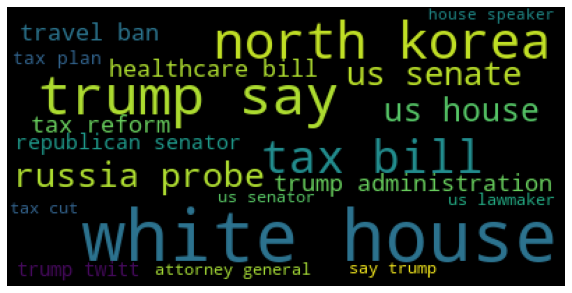

In [ ]:
topk = 20
print(f'\nShowing Top-{topk} bigrams found in True-news Titles')
disp_wordcloud_bigr(true_title_bigr_freq, topk)


Showing Top-20 bigrams found in True-news Texts


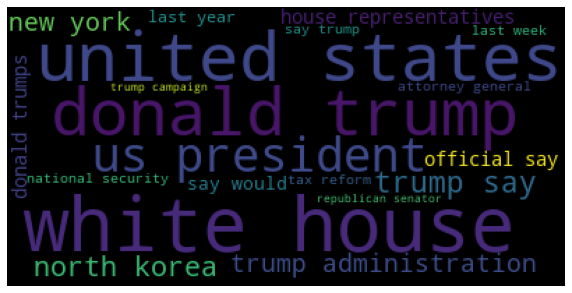

In [ ]:
topk = 20
print(f'\nShowing Top-{topk} bigrams found in True-news Texts')
disp_wordcloud_bigr(true_text_bigr_freq, topk)


Showing Top-20 bigrams found in Fake-news Titles


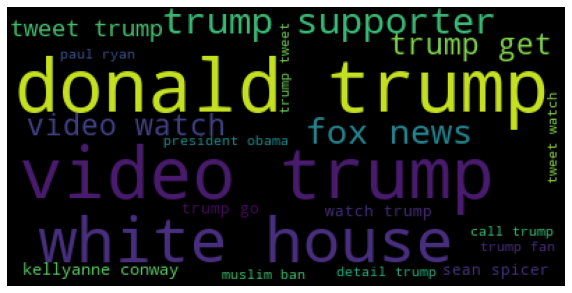

In [ ]:
topk = 20
print(f'\nShowing Top-{topk} bigrams found in Fake-news Titles')
disp_wordcloud_bigr(fake_title_bigr_freq, topk)


Showing Top-20 bigrams found in Fake-news Texts


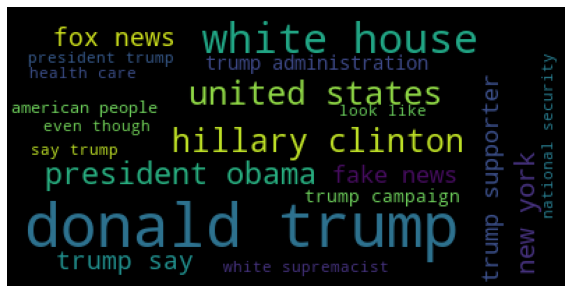

In [ ]:
topk = 20
print(f'\nShowing Top-{topk} bigrams found in Fake-news Texts')
disp_wordcloud_bigr(fake_text_bigr_freq, topk)

The results speak for themselves :-)

## 3. Train set and Test set creation

In [ ]:
# Merge fields "title" and "text" into a new field "content".
def merge_title_text(df):
    content = zip( df['title'].to_list(), df['text'].to_list() )
    df['content'] = [ str(title + text) for title, text in content ]    

# Create "content" field, add "label" field and drop every other pre-existing field.
def prepare_df(df, label):
    df['label'] = [ label for i in range(df.shape[0]) ]  # Add label
    merge_title_text(df)
    df.drop(columns = ['title', 'text', 'subject', 'date'], inplace=True)

In [ ]:
prepare_df(true_df_lem, 1)
prepare_df(fake_df_lem, 0)

In [ ]:
true_df_lem.head()

,label,content
0,1,as us budget fight loom republicans flip fisca...
1,1,us military to accept transgend recruit on mon...
2,1,senior us republican senator let mr mueller do...
3,1,fbi russia probe help by australian diplomat t...
4,1,trump want postal service to charge much more ...


In [ ]:
# Split the combined dataframe into test and train set.
combined = pd.concat([true_df_lem, fake_df_lem])
train_df, test_df = train_test_split(combined, train_size=0.5, random_state=420)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Store dataframes in .csv format.
test_df.to_csv (path_or_buf='test.csv',  columns=test_df.columns)
train_df.to_csv(path_or_buf='train.csv', columns=train_df.columns)

In [ ]:
train_df.tail()

,label,content
4484,1,pelosi say democrats will not back shortterm f...
4485,1,firm behind trump dossier decline to respond t...
4486,1,us house panel approve broad proposal on selfd...
4487,0,texas trump fan threaten to whip black man l...
4488,0,trump get a handed to by british lawmaker fo...


In [ ]:
test_df.tail()

,label,content
4485,1,what s in the final republican tax billreuters...
4486,0,trump embarrass with most pathetic twitter p...
4487,1,fellow republicans assail trump after defend c...
4488,0,texas supreme court just prove do not suppor...
4489,0,trump voter whine that husband can not get b...


## 4. Classification

### (a) Bag of Words representation

#### (0) Generate the representations

In [ ]:
# Get a representation based on a given vectorizer
def get_representation(vectorizer, train_df, test_df):
    # Collect labels
    y_train = train_df['label']
    y_test = test_df['label']
    # Vectorize training and testing set.
    # We use fit_transform() on the training set, in order to learn 
    # the parameters of scaling on the training set and in the same
    # time we scale the train data. We only use transform() on 
    # the testing set, because we use the scaling paramaters learned 
    # on the train data to scale the test data.
    x_train = vectorizer.fit_transform(train_df['content'])
    x_test = vectorizer.transform(test_df['content'])
    return x_train, y_train, x_test, y_test

In [ ]:
cv_rep = get_representation(CountVectorizer(), train_df, test_df)
tf_rep = get_representation(TfidfVectorizer(), train_df, test_df)

In [ ]:

# Applies a classification method to the given data and prints
# the classification report and the accuracy of the classifier
def __classify(method, x_train, y_train, x_test, y_test, wmean = False):
    # Make a pipeline consisting of a scaler and the classification method
    pipe = make_pipeline(StandardScaler(with_mean=wmean), method)
    # Apply scaling on training data
    pipe.fit(x_train, y_train)  
    # Apply scaling on testing data, without leaking training data.
    pipe.score(x_test, y_test)  

    y_pred = pipe.predict(x_test)
    # Print the report
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred);
    print('Accuracy is {:.2f} %'.format(accuracy*100))

# Applies a classification method to the given data and prints
# the classification report and the accuracy of the classifier. 
# Receives either a CountVectorizer() representation or 
# a TfidfVectorizer() representation.
def classify(method, cv_rep, tf_rep, tfid = False, toarr = False):
    # Extract the sets
    x_train, y_train, x_test, y_test = tf_rep if tfid else cv_rep
    # Convert to array if needed
    if toarr: x_train, x_test = x_train.toarray(), x_test.toarray()

    __classify(method, x_train, y_train, x_test, y_test, False)    

#### (1) Logistic Regression

In [ ]:
def sim_logistic_regression(cv_rep, tf_rep, tfid = False):
    classify(LogisticRegression(), cv_rep, tf_rep, tfid, False)

Simple count representation:

In [ ]:
sim_logistic_regression(cv_rep, tf_rep, False)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2277
           1       0.97      0.99      0.98      2213

    accuracy                           0.98      4490
   macro avg       0.98      0.98      0.98      4490
weighted avg       0.98      0.98      0.98      4490

Accuracy is 98.15 %


TF-IDF representation:

In [ ]:
sim_logistic_regression(cv_rep, tf_rep, True)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2277
           1       0.98      0.99      0.99      2213

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490

Accuracy is 98.69 %


#### (2) Naive Bayes

In [ ]:
def sim_naive_bayes(cv_rep, tf_rep, tfid = False):
    classify(GaussianNB(), cv_rep, tf_rep, tfid, True)

Simple count representation:

In [ ]:
sim_naive_bayes(cv_rep, tf_rep, False)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2277
           1       0.91      0.85      0.88      2213

    accuracy                           0.89      4490
   macro avg       0.89      0.88      0.89      4490
weighted avg       0.89      0.89      0.89      4490

Accuracy is 88.53 %


TF-IDF representation:

In [ ]:
sim_naive_bayes(cv_rep, tf_rep, True)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2277
           1       0.86      0.84      0.85      2213

    accuracy                           0.86      4490
   macro avg       0.86      0.85      0.85      4490
weighted avg       0.86      0.86      0.85      4490

Accuracy is 85.50 %


#### (3) SVM

In [ ]:
def sim_svc(parameters, cv_rep, tf_rep, tfid = False):
    classify(GridSearchCV(SVC(), parameters), cv_rep, tf_rep, tfid, False)

In [ ]:
parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}

Simple count representation:

In [ ]:
sim_svc(parameters, cv_rep, tf_rep, False)

              precision    recall  f1-score   support

           0       0.63      0.66      0.64      2277
           1       0.63      0.60      0.61      2213

    accuracy                           0.63      4490
   macro avg       0.63      0.63      0.63      4490
weighted avg       0.63      0.63      0.63      4490

Accuracy is 62.78 %


TF-IDF representation:

In [ ]:
sim_svc(parameters, cv_rep, tf_rep, True)

              precision    recall  f1-score   support

           0       0.61      0.77      0.68      2277
           1       0.68      0.50      0.58      2213

    accuracy                           0.64      4490
   macro avg       0.64      0.63      0.63      4490
weighted avg       0.64      0.64      0.63      4490

Accuracy is 63.61 %


#### (4) Random Forests

In [ ]:
def sim_random_forest(cv_rep, tf_rep, tfid = False):
    classify(RandomForestClassifier(), cv_rep, tf_rep, tfid, False)

Simple count representation:

In [ ]:
sim_random_forest(cv_rep, tf_rep, False)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2277
           1       1.00      0.99      1.00      2213

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Accuracy is 99.51 %


TF-IDF representation:

In [ ]:
sim_random_forest(cv_rep, tf_rep, True)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2277
           1       1.00      0.99      0.99      2213

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490

Accuracy is 99.20 %


### (b) Document-vectors representation

#### (0) Generate the representations

In [ ]:
# Returns a document-vectors array 
def transform_df(df, pre_ft_vectors):
    
    def get_doc_mean(pre_ft_vec, doc):
      return np.mean(np.array([ pre_ft_vec[w] for w in doc if w in pre_ft_vec ]), axis = 0)

    # Tokenize content
    tokens = [ word_tokenize(doc) for doc in df['content'].to_list() ]
    # Return the mean vectors of every token
    return np.array( [get_doc_mean(pre_ft_vectors, doc) for doc in tokens] )

def prepare_train_test(train_df, test_df):
    transf_train = transform_df(train_df, pre_ft_vectors)
    transf_test  = transform_df(test_df, pre_ft_vectors)
    y_train = train_df['label']
    y_test  = test_df['label']
    return transf_train, y_train, transf_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = prepare_train_test(train_df, test_df)

#### (1) Logistic Regression

In [ ]:
def sim2_logistic_regression(x_train, y_train, x_test, y_test):
    __classify(LogisticRegression(), x_train, y_train, x_test, y_test, True)

In [ ]:
sim2_logistic_regression(x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2277
           1       0.98      0.98      0.98      2213

    accuracy                           0.98      4490
   macro avg       0.98      0.98      0.98      4490
weighted avg       0.98      0.98      0.98      4490

Accuracy is 98.26 %


#### (2) Naive Bayes

In [ ]:
def sim2_naive_bayes(x_train, y_train, x_test, y_test):
    __classify(GaussianNB(), x_train, y_train, x_test, y_test, True)

In [ ]:
sim2_naive_bayes(x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2277
           1       0.93      0.93      0.93      2213

    accuracy                           0.93      4490
   macro avg       0.93      0.93      0.93      4490
weighted avg       0.93      0.93      0.93      4490

Accuracy is 93.21 %


#### (3) SVM

In [ ]:
def sim2_svc(parameters, x_train, y_train, x_test, y_test):
    __classify(GridSearchCV(SVC(), parameters), x_train, y_train, x_test, y_test, True)

In [ ]:
parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}
sim2_svc(parameters, x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2277
           1       0.99      0.98      0.99      2213

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490

Accuracy is 98.69 %


#### (4) Random Forests

In [ ]:
def sim2_random_forest(x_train, y_train, x_test, y_test):
    __classify(RandomForestClassifier(), x_train, y_train, x_test, y_test, True)

In [ ]:
sim2_random_forest(x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2277
           1       0.96      0.96      0.96      2213

    accuracy                           0.96      4490
   macro avg       0.96      0.96      0.96      4490
weighted avg       0.96      0.96      0.96      4490

Accuracy is 95.66 %


### Observations

#### Logistic Regression
**Logistic regression** is a linear classification method that learns the probability of a sample belonging to a certain class. Logistic regression tries to find the optimal decision boundary that best separates the classes.

Considering the learning mechanism, logistic regression is a discriminative model, meaning that it **directly** models the posterior probability of $P(y | x)$ by learning the input to output mapping by minimising the error.

Logistic regression splits feature space linearly, and typically works reasonably well even when some of the variables are correlated.

In the current app's data, logistic regression achieved classification accuracies of 98,15% using count vectorizer, 98,69% using TF-IDF vectorizer and 98,26% using document-vectors representation, meaning that data could easily be splitted linearly.

#### Naïve Bayes
**Naïve Bayes** is a classification method based on *Bayes’ theorem* that derives the probability of the given feature vector being associated with a label. Naïve Bayes has a naive assumption of conditional independence for every feature, which means that the algorithm **expects the features to be independent which not always is the case**.

The learning mechanism of Naive Bayes, is that it is a generative model. Naive Bayes models the joint distribution of the feature $X$ and target $Y$, and then predicts the posterior probability given as $P(y | x)$.

Naïve Bayes assumes all the features to be conditionally independent. So, if some of the features are in fact dependent on each other (in case of a large feature space), the prediction might be poor.

In the current app's data, Naïve Bayes achieved classification accuracies of 88,53% using count vectorizer, 85,55% using TF-IDF vectorizer and 93,21% using document-vectors representation, meaning that features where not fully independent (especially in TF-IDF representation) and as a result, the performance was less efficient compared to logistic regression.

#### SVM
**SVM** maximizes the *margin* and thus relies on the concept of *distance* between different points. So, *distance* might not be meaningful in some cases.

1. Works relatively well when there is a clear margin of separation between classes.
2. Is effective in cases where the number of dimensions is greater than the number of samples, but in cases where the number of features for each data point exceeds the number of training data samples, the SVM will underperform.
3. Does not perform very well when the data set has more noise i.e. target classes are overlapping.
4. As the support vector classifier works by putting data points, above and below the classifying hyperplane there is no probabilistic explanation for the classification.
5. Choosing a "good" kernel function is not easy.

In the current app's data, SVM achieved classification accuracies of 62,78% using count vectorizer, 63,61% using TF-IDF vectorizer and 98,68% using document-vectors representation. Notice the difference between the two first representations and the last one. Count vectorizer and TF-IDF vectorizer performed poorly, mostly because the number of samples is greater than the number of dimensions, whereas in the document-vectors representation, the classifier performed quite well, because the number of dimensions is greater than the number of samples.

#### Random Forests
**Random forests** or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees. Random Forest works well with a mixture of numerical and categorical features.  When features are on the various scales, it is also fine.  More specifically:

1. Emphasizes feature selection - weighs certain features as more important than others.
2. Does not assume that the model has a linear relationship - like regression models do.
3. Utilizes ensemble learning. If we were to use just 1 decision tree, we wouldn’t be using ensemble learning. 

In the current app's data, Random Forests had overall the best perfomance, by scoring classification accuracies of 99,47% using count vectorizer, 99,49% using TF-IDF vectorizer and 95,66% using document-vectors representation (average accuracy of 5 runs). 



## 5. Beat the benchmark

### What will be improved
In this section, the method that will be improved is the **Random Forests** classification method used on data represented by **TF-IDF** information retrieval technique.

### How it will be improved
We will improve the performance of the classifier by exporting hyperparameter-relevant statistics and therefore tuning the hyperparameters in order to maximize their effect on model performance.

### Evaluation procedure
The model's performace will be evaluated, by using scikit-learn's `RepeatedStratifiedKFold` and `cross_val_score` implementations. Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

### Which hyperparameters to tune
The hyperparameters in which the tuning will be performed are:

1. Number of samples.
2. Number of features.
3. Number of trees.
4. Tree depth.

### Benchmark score
The average (of 5 runs) benchmark accuracy that will we try to beat is **99.49%**.

In [ ]:
# Test max_samples hyperparameter.
def test_samples(start, stop, step):
	return {'%.1f' % i: rfc(max_samples=i if i != 1.0 else None) for i in arange(start, stop, step)}
 
# Test max_features hyperparameter.
def test_features(start, stop, step):
    return {str(i): rfc(max_features=i) for i in range(start, stop, step)}

# Test n_estimators hyperparameter.
def test_estimators(est):
    return {str(n): rfc(n_estimators=n) for n in est}

# Test max_depth hyperparameter.
def test_depth(depths):
    return {str(d): rfc(max_depth=d) for d in depths}

# Evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = kfold(n_splits=10, n_repeats=3, random_state=1)
    return cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
''' 
    Print statistical info and a boxplot, representing the 
    classifier's accuracy, given a testing function.
'''
def print_stats(test_func, X, y, args):
    
    # Perform testing
    models = test_func(*args)
    res, params = [], []
    print('param   mean   std \n-------------------')
    
    for param, model in models.items():
        # Perform evaluation
        eval = evaluate_model(model, X, y)
        # Store all the results
        res.append(eval)
        params.append(param)
        # Print statistical info
        print('%s     %.3f  %.3f' % (param, np.mean(eval), np.std(eval)))
    
    print('\n')
    # Plot model's performance
    plt.figure(figsize=(12, 8))
    plt.boxplot(res, labels=params, showmeans=True)
    plt.show()

x_train, y_train, x_test, y_test = tf_rep
X = x_train
y = y_train

Testing samples..
param   mean   std 
-------------------
0.1     0.985  0.006
0.2     0.988  0.005
0.3     0.990  0.004
0.4     0.990  0.005
0.5     0.992  0.005
0.6     0.992  0.004
0.7     0.992  0.004
0.8     0.992  0.004
0.9     0.992  0.004
1.0     0.992  0.004




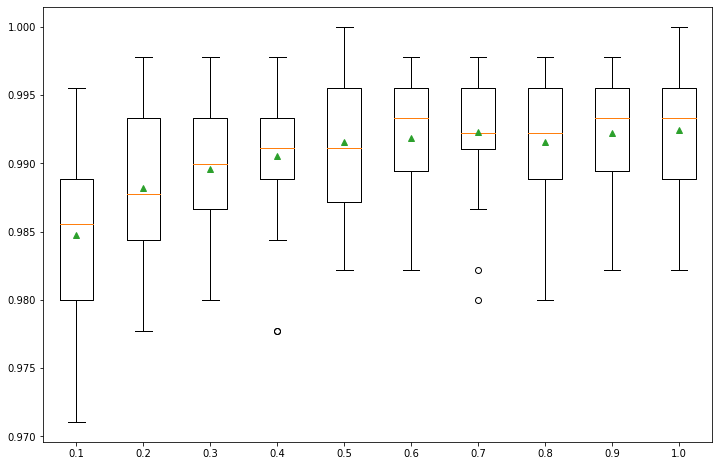

In [ ]:
print('Testing samples..')
print_stats(test_samples, X, y, [0.1, 1.1, 0.1])



Testing features..
param   mean   std 
-------------------
100     0.988  0.005
200     0.992  0.004
300     0.993  0.003
400     0.994  0.004
500     0.995  0.002
600     0.997  0.003
700     0.996  0.003
800     0.997  0.002




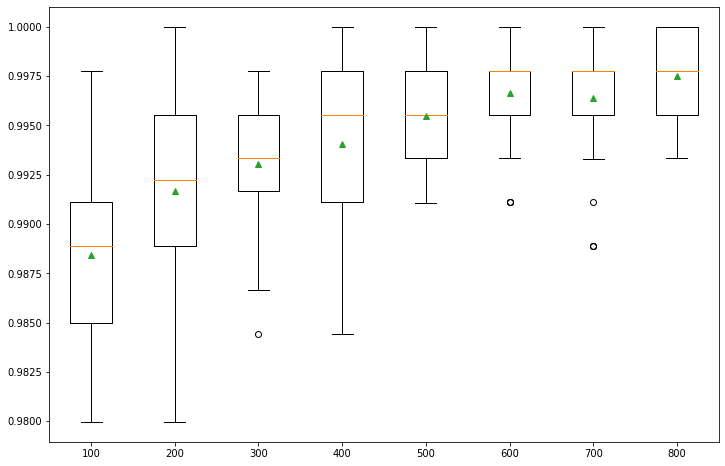

In [ ]:
print('\n\nTesting features..')
print_stats(test_features, X, y, [100, 900, 100])



Testing estimators..
param   mean   std 
-------------------
10     0.966  0.013
50     0.990  0.004
100     0.992  0.005
500     0.994  0.004
1000     0.994  0.004




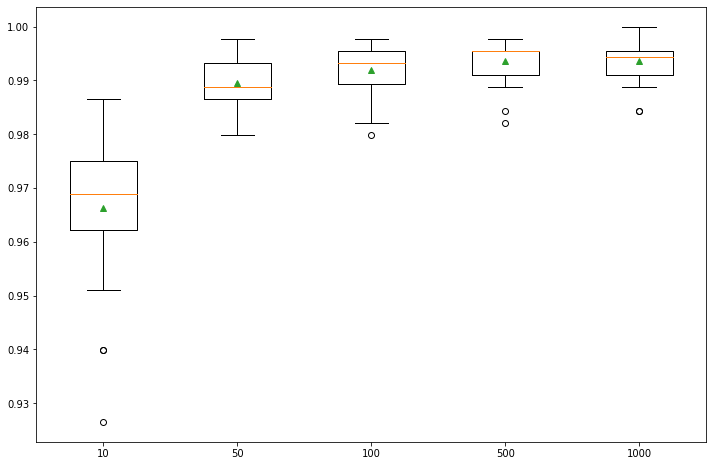

In [ ]:
print('\n\nTesting estimators..')
print_stats(test_estimators, X, y, [[10, 50, 100, 500, 1000]])



Testing depth..
param   mean   std 
-------------------
1     0.698  0.088
2     0.923  0.026
3     0.961  0.017
4     0.976  0.009
5     0.980  0.008
6     0.985  0.006
7     0.987  0.006
8     0.986  0.006
9     0.987  0.005
None     0.992  0.004




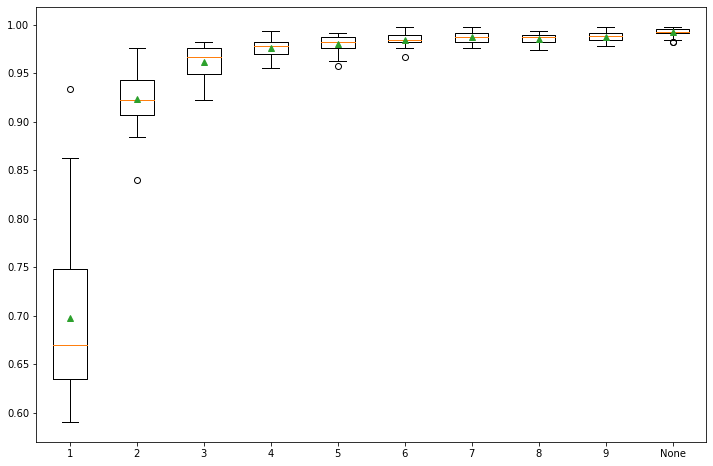

In [ ]:
print('\n\nTesting depth..')
print_stats(test_depth, X, y, [[i for i in range(1,10)] + [None]])

#### Improvements procedure

Based on all of the above box diagrams, the most suitable set of hyperparameters for this dataset is:

1. Maximum samples: $0.9$
2. Maximum features: $500$
3. Number of estimators: $500$
4. Maximum depth: None

In [ ]:
# Define the tuned version of Random Forests classifier
def sim_random_forest_tuned(cv_rep, tf_rep, tfid = False):
    classify(RandomForestClassifier(max_samples=0.9, max_features=500, n_estimators=500, max_depth=None), cv_rep, tf_rep, tfid, False)

In [ ]:
sim_random_forest_tuned(cv_rep, tf_rep, True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2277
           1       1.00      1.00      1.00      2213

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Accuracy is 99.71 %


#### Results

After hyperparameter tuning, the improved random forests method has an average (of 5 runs) accuracy of **99.71%**.

#### References
*[How to Develop a Random Forest Ensemble in Python](https://machinelearningmastery.com/random-forest-ensemble-in-python/)*